In [49]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.callbacks import Callback
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [51]:
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [52]:
conflict_rows = train_df[(train_df['PAQ_A-PAQ_A_Total'].notna()) & (train_df['PAQ_C-PAQ_C_Total'].notna())]

# 判斷是否存在衝突行
if not conflict_rows.empty:
    train_df = train_df.drop(conflict_rows.index)

In [53]:
# 將合併結果存回 column1
train_df['PAQ_A-PAQ_A_Total'] = train_df['PAQ_A-PAQ_A_Total'].fillna(train_df['PAQ_C-PAQ_C_Total'])
train_df['PAQ_A-Season'] = train_df['PAQ_A-Season'].fillna(train_df['PAQ_C-Season'])
test_df['PAQ_A-PAQ_A_Total'] = test_df['PAQ_A-PAQ_A_Total'].fillna(test_df['PAQ_C-PAQ_C_Total'])
test_df['PAQ_A-Season'] = test_df['PAQ_A-Season'].fillna(test_df['PAQ_C-Season'])

# 刪除 column2
train_df = train_df.drop(columns=['PAQ_C-PAQ_C_Total', 'PAQ_C-Season'])
test_df = test_df.drop(columns=['PAQ_C-PAQ_C_Total', 'PAQ_C-Season'])

train_df = train_df.rename(columns={'PAQ_A-Season': 'PAQ-Season'})
train_df = train_df.rename(columns={'PAQ_A-PAQ_A_Total': 'PAQ-PAQ_Total'})
test_df = test_df.rename(columns={'PAQ_A-Season': 'PAQ-Season'})
test_df = test_df.rename(columns={'PAQ_A-PAQ_A_Total': 'PAQ-PAQ_Total'})

In [54]:
df = train_df.dropna(axis=1, thresh=len(train_df) - 3000)

In [55]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

In [56]:
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [57]:
# 把SII是空的column刪除
train_df = train_df.dropna(subset=['sii'])

In [58]:
# PCIAT 有些欄位是空的，會影響最後SII結果，把若填滿PCIAT有可能改變SII的column刪除
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
def IncorrectRows(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train_df['recal_sii'] = train_df.apply(IncorrectRows, axis=1)

In [59]:
mismatch_rows = train_df[
    (train_df['recal_sii'] != train_df['sii']) & train_df['sii'].notna()
]
mismatch_indexes = mismatch_rows.index
train_df = train_df.drop(mismatch_indexes)
train_df = train_df.drop(['recal_sii'], axis=1)

In [60]:
# 把有關Season的column做mapping 
SEASON_COLS = [
    "Basic_Demos-Enroll_Season", 
    "CGAS-Season", 
    "Physical-Season", 
    "Fitness_Endurance-Season", 
    "FGC-Season", 
    "BIA-Season", 
    "PAQ-Season",
    "SDS-Season",
    "PreInt_EduHx-Season", 
    ]
def update(df):
    for c in SEASON_COLS: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
train_df = update(train_df)
test_df = update(test_df)
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3, 'Missing': 4}
for col in SEASON_COLS:
    train_df[col] = train_df[col].map(season_mapping)
    test_df[col] = test_df[col].map(season_mapping)
train_df['PCIAT-Season'] = train_df['PCIAT-Season'].map(season_mapping)

In [61]:
# 做Imputer
train_id = train_df['id']
test_id = test_df['id']
train_features = train_df.drop(columns=['id'])
test_features = test_df.drop(columns=['id'])

imputer = SimpleImputer(strategy='median')
train_features_imputed = pd.DataFrame(imputer.fit_transform(train_features), columns=train_features.columns, index=train_features.index)
test_features_imputed = pd.DataFrame(imputer.fit_transform(test_features), columns=test_features.columns, index=test_features.index)

train_df = pd.concat([train_id, train_features_imputed], axis=1)
test_df = pd.concat([test_id, test_features_imputed], axis=1)

In [62]:
train_cor = train_df.drop('id', axis=1)
test_cor = test_df.drop('id', axis=1)

In [63]:
# 尋找和PCIAT_Total相關性低的column並刪除 
corr_matrix = train_cor[['PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 
                        'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                        'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
                        'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ-PAQ_Total',
                        'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 
                        'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 
                        'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 
                        'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                        'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 
                        'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']].corr()
sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.1) | (sii_corr < -0.1)]
other_corr = sii_corr[(sii_corr <= 0.1) & (sii_corr >= -0.1)]
other_corr_columns = other_corr.index.tolist()
print(other_corr)

Basic_Demos-Sex               -0.094312
Physical-Diastolic_BP          0.066374
Physical-HeartRate            -0.035771
PAQ-PAQ_Total                 -0.042217
Fitness_Endurance-Max_Stage   -0.020330
Fitness_Endurance-Time_Mins   -0.038346
Fitness_Endurance-Time_Sec     0.001800
FGC-FGC_SRL                   -0.073663
FGC-FGC_SRR                   -0.064219
BIA-BIA_Activity_Level_num     0.075633
BIA-BIA_BMC                   -0.007859
BIA-BIA_BMR                    0.028779
BIA-BIA_DEE                    0.041886
BIA-BIA_ECW                    0.027491
BIA-BIA_FFM                    0.028779
BIA-BIA_FFMI                   0.085982
BIA-BIA_FMI                    0.066753
BIA-BIA_Fat                    0.031164
BIA-BIA_ICW                    0.041286
BIA-BIA_LDM                    0.019975
BIA-BIA_LST                    0.059496
BIA-BIA_SMM                    0.041344
BIA-BIA_TBW                    0.033559
Name: PCIAT-PCIAT_Total, dtype: float64


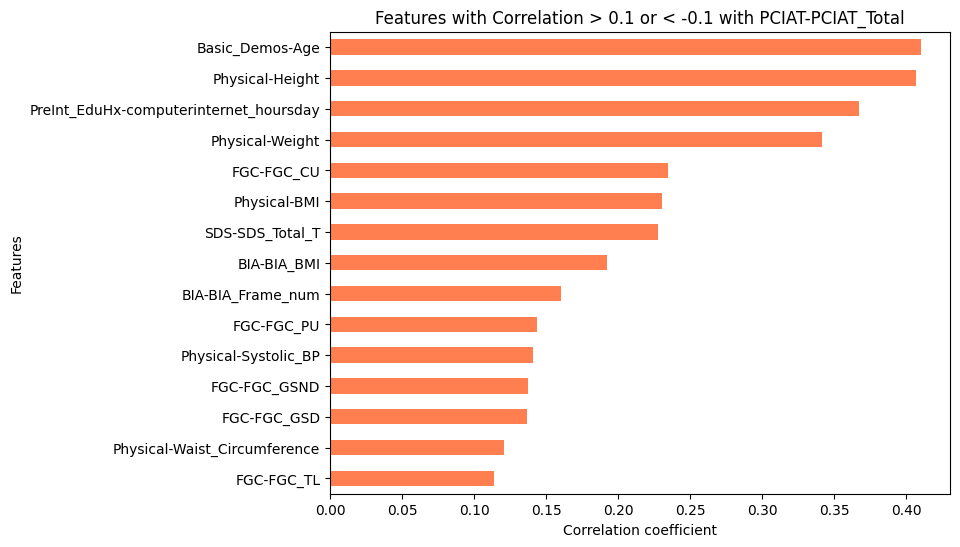

In [64]:
plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

In [65]:
train_df = train_df.drop(columns=other_corr_columns)
test_df = test_df.drop(columns=other_corr_columns)

In [66]:
# 把parquet data加進去 
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

train_ts_noID = train_ts.drop('id', axis=1)
test_ts_noID = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(train_ts_noID, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(test_ts_noID, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

100%|██████████| 2/2 [00:00<00:00, 12.84it/s]


Epoch [10/100], Loss: 1.6832]
Epoch [20/100], Loss: 1.6234]
Epoch [30/100], Loss: 1.5770]
Epoch [40/100], Loss: 1.5321]
Epoch [50/100], Loss: 1.5061]
Epoch [60/100], Loss: 1.4970]
Epoch [70/100], Loss: 1.4968]
Epoch [80/100], Loss: 1.4973]
Epoch [90/100], Loss: 1.4980]
Epoch [100/100], Loss: 1.4942]
Epoch [10/100], Loss: 1.0089]
Epoch [20/100], Loss: 0.6029]
Epoch [30/100], Loss: 0.4271]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


In [67]:
TARGET_COLS = [
    "PCIAT-Season",
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",    
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total"
]
train_df = train_df.drop(TARGET_COLS,axis=1)

In [68]:
train_df = pd.merge(train_df, train_ts_encoded, how="left", on='id')
test_df = pd.merge(test_df, test_ts_encoded, how="left", on='id')

In [70]:
imputer = KNNImputer(n_neighbors=5)
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train_df[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train_df.columns:
    if col not in numeric_cols:
        train_imputed[col] = train_df[col]
        
train_df = train_imputed

train_df = feature_engineering(train_df)
train_df = train_df.dropna(thresh=10, axis=0)
test_df = feature_engineering(test_df)

In [71]:
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [72]:
print(f'Train Shape : {train_df.shape} || Test Shape : {test_df.shape}')

Train Shape : (2718, 94) || Test Shape : (20, 93)


In [73]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [74]:
from imblearn.over_sampling import SMOTE
X_train = train_df.drop(columns=['sii'])  # 假設 'sii' 是目標欄位
y_train = train_df['sii']

# 使用 SMOTE 進行過採樣
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_resampled

In [ ]:
y_train_resampled

In [75]:
X_train = X_train_resampled
y_train = y_train_resampled
X_test = test_df

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# model = TabNetRegressor(
#     n_d=64,              # Width of the decision prediction layer
#     n_a=64,              # Width of the attention embedding for each step
#     n_steps=5,           # Number of steps in the architecture
#     gamma=1.5,           # Coefficient for feature selection regularization
#     n_independent=2,     # Number of independent GLU layer in each GLU block
#     n_shared=2,          # Number of shared GLU layer in each GLU block
#     lambda_sparse=1e-4,  # Sparsity regularization
#     optimizer_fn=torch.optim.Adam,
#     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
#     mask_type='entmax',
#     scheduler_params=dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
#     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
#     verbose=1,
#     device_name='cuda' if torch.cuda.is_available() else 'cpu'
# )


# # 訓練 TabNet 模型
# model.fit(
#     X_train, y_train,
#     max_epochs=500,      
#     patience=50,          
#     batch_size=1024,
#     virtual_batch_size=128,
#     num_workers=0,
#     drop_last=False,
# )


test_df['sii'] = model.predict(X_test)

In [76]:
submit_df = pd.concat([test_id, test_df['sii']], axis=1)
submit_df['sii'] = submit_df['sii'].astype(int)

In [77]:
submit_df

,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,2
5,001f3379,0
6,0038ba98,0
7,0068a485,0
8,0069fbed,0
9,0083e397,0


In [ ]:
submit_df.to_csv('submission.csv', index=False)